In [17]:
#@title Colab Imports

import sys
import time
import os
import madi
from madi.utils import file_utils
from madi.utils import evaluation_utils
import numpy as np
import pandas as pd
from typing import Tuple, List, Dict
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib as mpl
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold

from madi.datasets import positive_sample_dataset
from madi.detectors.neg_sample_neural_net_detector import NegativeSamplingNeuralNetworkAD
from madi.detectors.integrated_gradients_interpreter import IntegratedGradientsInterpreter

import tensorflow as tf
assert tf.version.VERSION > '2.1.0'

# Select a dataset

In [18]:
#@title Choose the data set
_RESOURCE_LOCATION = "madi.datasets.data"
data_source = "positive_sample" #@param ["gaussian_mixture", "smart_buildings"]
ds = None

class InvalidDatasetError(ValueError):
    pass

if data_source == 'positive_sample':
    
    data_file = file_utils.PackageResource(_RESOURCE_LOCATION, "positive_sample.csv")
    readme_file = file_utils.PackageResource(_RESOURCE_LOCATION, "positive_sample_README.md")
    ds = madi.datasets.positive_sample_dataset.PositiveSampleDataset(data_file)
    print(ds.description)

else:
  raise InvalidDatasetError("You requested an invalid data set (%s)." %data_source)


print('Randomize the data, and split into training and test sample.')
split_ix = int(len(ds.sample) * 0.8)
training_sample = ds.sample.iloc[:split_ix]
test_sample = ds.sample.iloc[split_ix:]
print("\tTraining sample size: %d" %len(training_sample))
print("\tTest sample size: %d" %len(test_sample))

The positive sample dataset consists of 4,032 multidimensional observations. 
 The dataset consists of 4032 rows and seven columns. 
 These are the test dataset that we will be using in this project.

Randomize the data, and split into training and test sample.
	Training sample size: 3225
	Test sample size: 807


In [17]:
#print(sample)

In [16]:
#print(split_ix)

In [13]:
#print(training_sample)

In [14]:
#print(test_sample)

# Configure Anomaly Detectors

In [19]:
#@title Reset Anomlay Detectors
ad_dict = {}
log_dir = "logs/nsnn2" #@param {type:"string"}

In [20]:
# Create directory
os.makedirs(log_dir, exist_ok=True)

In [22]:
# Neg Sampling Neural Net Parameters
nsnn_params = {}


if data_source == 'positive_sample':
    
    nsnn_params['sample_ratio']=25.0
    nsnn_params['sample_delta']=0.05
    nsnn_params['batch_size']=32
    nsnn_params['steps_per_epoch']=16
    nsnn_params['epochs']=100
    nsnn_params['dropout']=0.85
    nsnn_params['layer_width']=150
    nsnn_params['n_hidden_layers']=2

else:
    raise InvalidDatasetError("You requested an invalid data set (%s)." %data_source)

print(nsnn_params)

{'sample_ratio': 25.0, 'sample_delta': 0.05, 'batch_size': 32, 'steps_per_epoch': 16, 'epochs': 100, 'dropout': 0.85, 'layer_width': 150, 'n_hidden_layers': 2}


In [23]:
#@title Add in Negative Sampling Neural Net (ns-nn)
ad_dict['ns-nn'] = NegativeSamplingNeuralNetworkAD(
        sample_ratio=nsnn_params['sample_ratio'],
        sample_delta=nsnn_params['sample_delta'],
        batch_size=nsnn_params['batch_size'],
        steps_per_epoch=nsnn_params['steps_per_epoch'],
        epochs=nsnn_params['epochs'],
        dropout=nsnn_params['dropout'],
        layer_width=nsnn_params['layer_width'],
        n_hidden_layers=nsnn_params['n_hidden_layers'],
        log_dir=log_dir)

print('Anomaly Detectors: ', list(ad_dict))

Anomaly Detectors:  ['ns-nn']


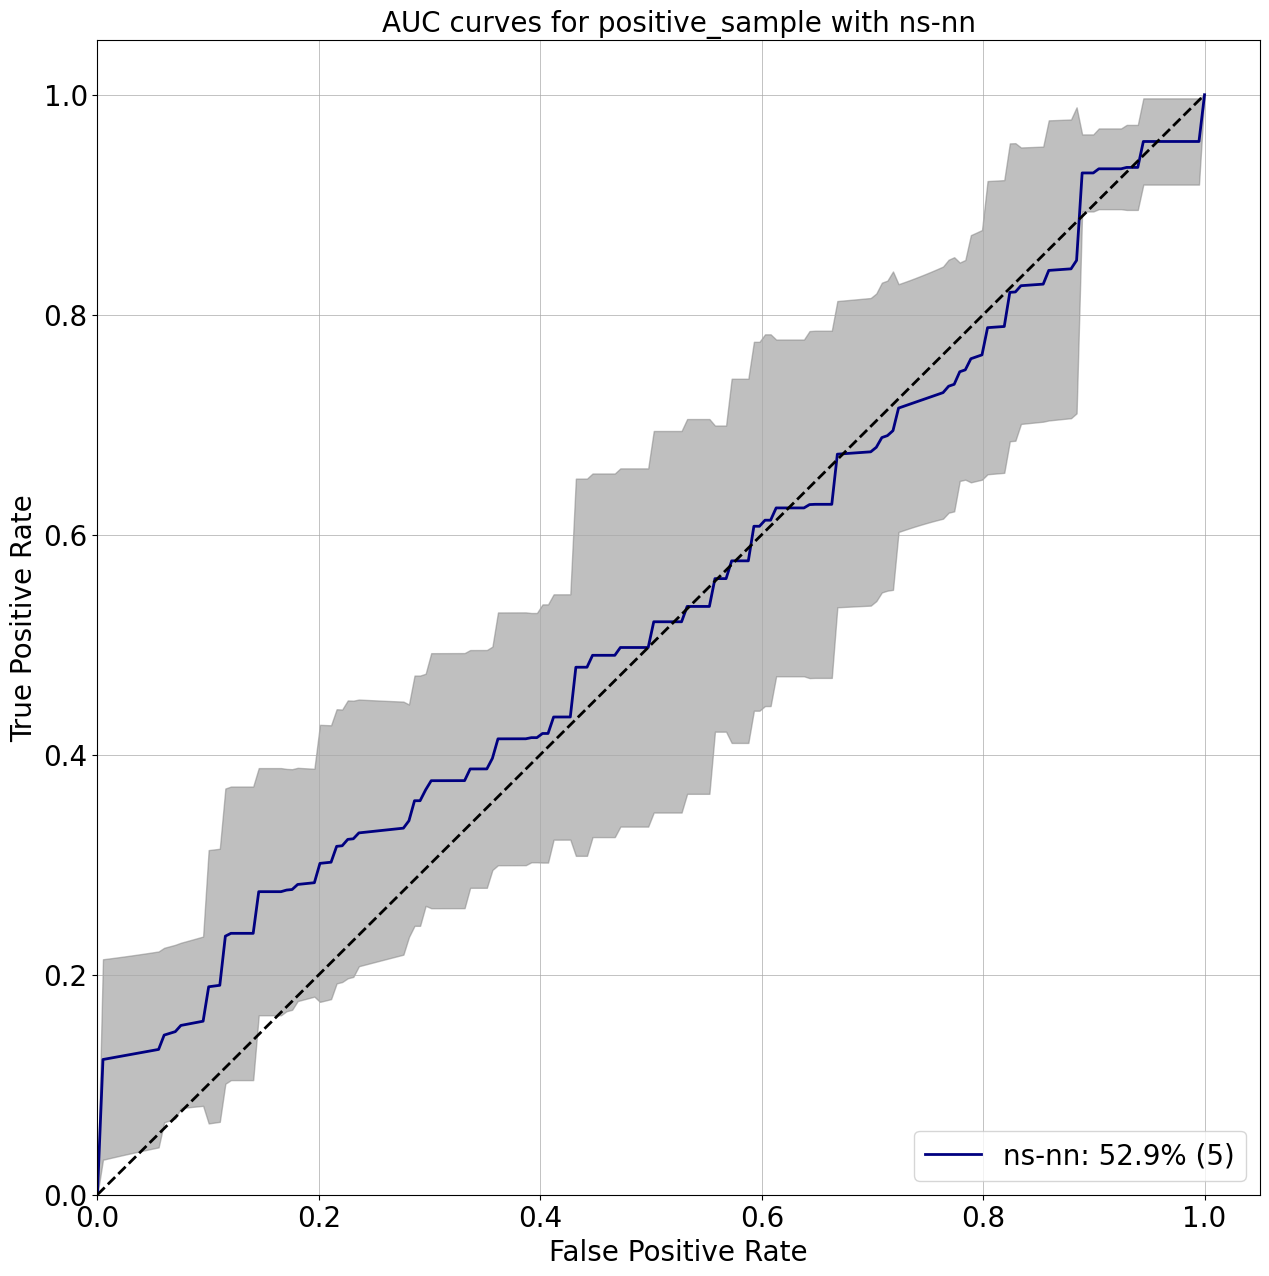

Final Results:
                 ad       auc    extime
000-00-ns-nn  ns-nn  0.356605  6.166022
000-01-ns-nn  ns-nn  0.615809  7.119477
000-02-ns-nn  ns-nn  0.533250  7.432168
000-03-ns-nn  ns-nn  0.508872  8.292052
000-04-ns-nn  ns-nn  0.629600  6.997557


In [24]:
#@title Execute Cross-Fold Validation {output-height:"unlimited"}
number_crossfolds =  1#@param {type:"integer"}
number_folds =  5#@param {type:"integer"}


def fold_sample(sample: pd.DataFrame, n_folds: int = 5) ->  List[Dict[str, pd.DataFrame]]:
  """Splits a sample into N folds.
  
  Args:
    sample: training/test sample to be folded.
  """
  sample = shuffle(sample)
  print(sample)
  
  folds = []
  # Split into train and test folds, and assign to list called folds.
  for training_sample_idx, test_sample_idx in KFold(n_splits=5).split(sample):
    test_sample = sample.iloc[test_sample_idx]
    training_sample = sample.iloc[training_sample_idx]
    folds.append({"train": training_sample, "test": test_sample})
  return folds


def plot_auc(ad_results: Dict[str, Dict[str, Dict[str, np.array]]], 
             experiment_name: str):
  """Plots the ROC AUC. """
  
  fig, ax = plt.subplots(figsize=(15, 15))
  start = 0.0
  stop = 1.0
  colors = [cm.jet(x) for x in np.linspace(start, stop, len(ad_results))]

  df_auc = pd.DataFrame()

  lw = 2
  ix = 0
  for ad_id in ad_results:

    fold_results = ad_results[ad_id]
    vfprs = []
    vtprs = []

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 200)
    validation_aucs = []
    for fold_id in fold_results:
      fpr = fold_results[fold_id]['fpr']
      tpr = fold_results[fold_id]['tpr']

      validation_auc_val = auc(fpr, tpr)
      validation_aucs.append(validation_auc_val)    
      interp_tpr = np.interp(mean_fpr, fpr, tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)

    mean_tpr = np.mean(tprs, axis=0)
  
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(validation_aucs)
    df_auc[ad_id] = [mean_auc]

    plt.plot(mean_fpr, mean_tpr, color=colors[ix], lw=lw, 
             label='%s: %0.1f%% (%d)' % (
                 ad_id, 100.0 * mean_auc, len(fold_results) ))
    ix+=1

    std_tpr = np.std(tprs, axis=0)
    
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='gray', alpha=0.5,
                label=None)
    
  ax.grid(linestyle='-', linewidth='0.5', color='darkgray')
  plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.05])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('AUC curves for %s' %experiment_name)
  
  legend = plt.legend(loc='lower right', shadow=False, fontsize='20')
  legend.get_frame().set_facecolor('white')

  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
  
  for sp in ax.spines:
    ax.spines[sp].set_color("black")

  plt.show()

anomaly_detectors = sorted(list(ad_dict))
experiment_name = "%s with %s" %(ds.name, ", ".join(anomaly_detectors))

df_results = pd.DataFrame(columns = ['ad', 'auc', 'extime'])
ad_results = {}

for ad in anomaly_detectors:

  if ad not in ad_results:
    ad_results[ad] = {}

  for cx_run in range(number_crossfolds):
    folds = fold_sample(ds.sample, n_folds = number_folds)

    for fid in range(number_folds):
      
      fold = folds[fid]

      # Drop the class label from the training sample, since this is unsupervised.
      training_sample = fold['train'].copy()
      testing_sample = fold['test'].copy()
      X_train = training_sample.drop(columns = ['class_label'])
      X_test  = testing_sample.drop(columns = ['class_label'])
      y_test  = testing_sample['class_label']

      start_time = time.time()

      # Train a model in the training split.
      ad_dict[ad].train_model(x_train=X_train)

      # Predict on the test set.
      y_predicted = ad_dict[ad].predict(X_test)['class_prob']

      # Compute the AUC on the test set. 
      auc_value = madi.utils.evaluation_utils.compute_auc(
              y_actual=y_test, y_predicted=y_predicted)
        
      # Compute the ROC curve.
      fpr, tpr, _ = roc_curve(y_test, y_predicted)

      end_time = time.time()
      extime = end_time - start_time
      ad_results[ad]['%03d-%02d' %(cx_run, fid)] = {'fpr': fpr, 'tpr':tpr}
      df_results.loc['%03d-%02d-%s' %(cx_run, fid, ad)] = [ad, auc_value, extime]

      # Refresh the output area.
      clear_output()
      
      plot_auc(ad_results, experiment_name  = experiment_name)
      
      del training_sample
      del testing_sample
print("Final Results:")
print(df_results)

In [26]:
#@title Colab Imports
import sys
import madi
from madi.utils import file_utils
import numpy as np
import pandas as pd
from typing import List, Dict
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib as mpl
import seaborn as sns

from madi.datasets import positive_sample_dataset
from madi.detectors.neg_sample_neural_net_detector import NegativeSamplingNeuralNetworkAD
from madi.detectors.integrated_gradients_interpreter import IntegratedGradientsInterpreter

import tensorflow as tf
assert tf.version.VERSION > '2.1.0'

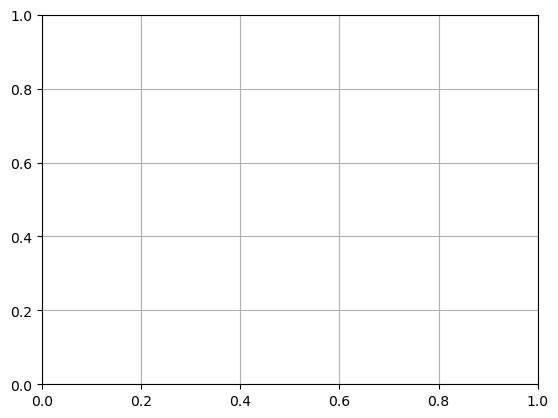

In [29]:
#@title Plotting utilities
def plot_attribution(df_attribution: pd.DataFrame, anomaly_score: float) -> None:
  """Plots the attribution as a pie chart.

  The center contains the anmomaly score. The wedges are ordered clockwise
  from the most blame to the least. The percentages are the normalized
  percentages (Blame(d) / Sum of Blames). The values outside the wedges
  indicate the observed value, and the expected value in parentheses.

  Args:
    df_attribution: dataframe with observed_value, expected_value, and
    attribution for each dimension.
    anomaly_score: score ranging between Normal (1) and Anomalous (0).

  """
  df_attribution = df_attribution.sort_values(by='attribution', ascending=False)
  norm = plt.Normalize()
  names=[]
  sizes = []
  sum_big = 0
  for fn, row in df_attribution.iterrows():
    # Only show the dimensions with a blame > 5%.
    if row.attribution > 0.05:
      names.append('%s\n%3.1f (%3.1f)' %(fn, row.observed_value, row.expected_value))
      wedge_size = int(100* row.attribution)
      sum_big += wedge_size
      sizes.append(wedge_size)
  names.append('other')
  sizes.append(int(100 - sum_big))

  # Create a circle for the center of the plot
  num_p_score_steps = 100
  center_color_index  = int(num_p_score_steps*anomaly_score)
  my_circle=plt.Circle( (0,0), 0.45, facecolor=plt.cm.RdYlGn(
      norm(range(num_p_score_steps+1)))[center_color_index],
      edgecolor='white', linewidth=3)

  fig, ax = plt.subplots()
  fig.set_figheight(10)
  fig.set_figwidth(10)

  center_text = "%.2f" %(anomaly_score)
  if (center_color_index < 20 ) or (center_color_index > 80):
    text_color = 'white'
  else:
    text_color = 'black'
  ax.text(0,0,center_text, fontsize=28,horizontalalignment='center',
          color=text_color, weight="bold")

  # Custom colors --> colors will cycle
  norm = plt.Normalize()
  # Choose nine colors to cycle through to show contrast between slices.
  pie_plot = plt.pie(sizes, labels=names, colors=plt.cm.RdYlBu(norm(range(9)), alpha=0.6),
                     startangle=90, counterclock=False, autopct='%1.0f%%',
                     pctdistance=0.70, textprops=
                     dict(color="black", weight="bold", fontsize=28))

  for lab in pie_plot[1]:
    lab.set_fontsize(28)
    p=plt.gcf()
    p.gca().add_artist(my_circle)
plt.show()

def plot_gradient_series(df_grad: pd.DataFrame, delta: np.array) -> None:
    fig, ax = plt.subplots()
    fig.set_figheight(12)
    fig.set_figwidth(15)
    n_points = len(df_grad)
    colors = sns.color_palette('rainbow', df_grad.shape[1])
    for ix, field_name in enumerate(df_grad):
      series_color = colors[ix]
      ig_series = (df_grad[field_name].cumsum()/float(n_points)) * delta[field_name]
      ax.plot(df_grad.index, ig_series , linewidth=3.0, linestyle='-', marker=None, color=series_color)

    ax.grid(linestyle='-', linewidth='0.5', color='darkgray')

    legend = plt.legend(loc='upper left', shadow=False, fontsize='16', bbox_to_anchor=(1, 1), labels = list(df_grad))
    legend.get_frame().set_facecolor('white')
    plt.ylabel('Cumulative Gradients')

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(24)

    for sp in ax.spines:
       ax.spines[sp].set_color("black")
    ax.set_facecolor("white")

plt.grid(True)
plt.show()

In [31]:
#@title Choose the data set
_RESOURCE_LOCATION = "madi.datasets.data"
data_source = "positive_sample" #@param ["gaussian_mixture", "smart_buildings"]
ds = None

class InvalidDatasetError(ValueError):
    pass

if data_source == 'positive_sample':
    data_file = file_utils.PackageResource(_RESOURCE_LOCATION, "positive_sample.csv")
    readme_file = file_utils.PackageResource(_RESOURCE_LOCATION, "positive_sample_README.md")
    ds = madi.datasets.positive_sample_dataset.PositiveSampleDataset(data_file, readme_file)
    print(ds.description)
    
else:
    raise InvalidDatasetError("You requested an invalid data set (%s)." %data_source)


print('Randomize the data, and split into training and test sample.')
split_ix = int(len(ds.sample) * 0.8)
training_sample = ds.sample.iloc[:split_ix]
test_sample = ds.sample.iloc[split_ix:]
print("\tTraining sample size: %d" %len(training_sample))
print("\tTest sample size: %d" %len(test_sample))

The positive sample dataset consists of 4,032 multidimensional observations. 
 The dataset consists of 4032 rows and seven columns. 
 These are the test dataset that we will be using in this project.

Randomize the data, and split into training and test sample.
	Training sample size: 3225
	Test sample size: 807


In [32]:
#@title Train a Negative Sampling Neural Net (NS-NN) Anomaly Detector
log_dir = "logs/nsnn2" #@param {type:"string"}

nsnn_params = {}

if data_source == 'positive_sample':
    nsnn_params['sample_ratio']=25.0
    nsnn_params['sample_delta']=0.05
    nsnn_params['batch_size']=32
    nsnn_params['steps_per_epoch']=16
    nsnn_params['epochs']=88
    nsnn_params['dropout']=0.5
    nsnn_params['layer_width']=128
    nsnn_params['n_hidden_layers']=2

else:
  raise InvalidDatasetError("You requested an invalid data set (%s)." %data_source)

print(nsnn_params)
X_train = training_sample.drop(columns = ['class_label'])

# It's very important to normalize the data for both classification and
# anomaly detection.
y_train = training_sample['class_label']

# We shall reuse the normalization info from training for test.
X_test = test_sample.drop(columns = ['class_label'])
y_test= test_sample['class_label']

# Declare the AD and parameterize it.
ad = NegativeSamplingNeuralNetworkAD(
        sample_ratio=nsnn_params['sample_ratio'],
        sample_delta=nsnn_params['sample_delta'],
        batch_size=nsnn_params['batch_size'],
        steps_per_epoch=nsnn_params['steps_per_epoch'],
        epochs=nsnn_params['epochs'],
        dropout=nsnn_params['dropout'],
        layer_width=nsnn_params['layer_width'],
        n_hidden_layers=nsnn_params['n_hidden_layers'],
        log_dir=log_dir)

# Build the sample and train the AD classifier model.
ad.train_model(x_train=X_train)

xy_predicted = ad.predict(X_test)

auc = madi.utils.evaluation_utils.compute_auc(
      y_actual=y_test, y_predicted=xy_predicted['class_prob'])

print("The AUC against the test set is %0.3f" %auc)

{'sample_ratio': 25.0, 'sample_delta': 0.05, 'batch_size': 32, 'steps_per_epoch': 16, 'epochs': 88, 'dropout': 0.5, 'layer_width': 128, 'n_hidden_layers': 2}
1/1 [==============================] - 0s 37ms/step
The AUC against the test set is 0.397


In [33]:
#@title Set up the anomaly interpreter.


min_class_confidence = 0.99 #@param {type:"number"}
max_baseline_size = 500 #@param {type:"integer"}

try:
  X_train_normalized = madi.utils.sample_utils.normalize(X_train, ad._normalization_info)
  interpreter = madi.detectors.integrated_gradients_interpreter.IntegratedGradientsInterpreter(
          ad._model, X_train_normalized,
          min_class_confidence, max_baseline_size,num_steps_integrated_gradients = 2000)
  print('Variable Attibution is ready with a baseline sample size of %d points.' %len(interpreter._df_baseline))
except madi.detectors.integrated_gradients_interpreter.NoQualifyingBaselineError as err:
  print(err.message)
  print('Assign min_class_confidence to a value below %0.2f to accumulate a baseline sample.' %err.highest_class_confidence)
  print('Variable Attibution is NOT ready.')

1/1 [==============================] - 0s 29ms/step


KeyError: 500

In [34]:
#@title Generate the sliders for interactive control.

def get_variable_slider(variable_name:str, mean:float, std:float, default:float) -> str:
  if "percent" in variable_name:
    min_val = 0
    max_val = 100
    step = 1
  elif "temperature" in variable_name:
    min_val = 250
    max_val = 350
    step = 1
  elif variable_name == "dow":
    min_val = 0
    max_val = 6
    step = 1
  elif variable_name == "hod":
    min_val = 0
    max_val = 23
    step = 1
  else:
    min_val = mean - 6 * std
    max_val = mean + 6 * std
    step = (max_val - min_val)/100.0

  var_name_base = variable_name.replace("data:", "")
  return """%s = %f #%sparam {type:"slider", min:%f, max:%f, step:%f}""" %(var_name_base, default, "@", min_val, max_val, step )

def get_var_assignment(variable_name: str) -> str:
  var_name_base = variable_name.replace("data:", "")
  return """observed_point['%s'] = [%s]""" %(variable_name, var_name_base)

def get_sliders(normalization_info: Dict[str, madi.utils.sample_utils.Variable], baseline: pd.DataFrame):
  column_order = madi.utils.sample_utils.get_column_order(normalization_info)
  slider_strings  = []
  for col in column_order:
    slider_strings.append(get_variable_slider(col, normalization_info[col].mean, normalization_info[col].std, baseline[col]))
  return "\n".join(slider_strings)

def get_var_assignments(normalization_info):
  column_order = madi.utils.sample_utils.get_column_order(normalization_info)
  assignment_strings  = []
  for col in column_order:
    assignment_strings.append(get_var_assignment(normalization_info[col].name))
  return "\n".join(assignment_strings)

df_reference_point_selected_normalized = interpreter._df_baseline.iloc[[0]]
df_reference_point_selected =madi.utils.sample_utils.denormalize(df_reference_point_selected_normalized, ad._normalization_info)

print(get_sliders(ad._normalization_info,df_reference_point_selected.iloc[0]))
print(get_var_assignments(ad._normalization_info))

NameError: name 'interpreter' is not defined

In [35]:
#@title Visualize variable attribution. { vertical-output: false, run: "auto" }

np.set_printoptions(threshold=sys.maxsize)
column_order = madi.utils.sample_utils.get_column_order(ad._normalization_info)
observed_point = {}

################################################################
#vv Copy and paste the text from the cell into the area below.vv
################################################################
print('If you\'re getting an error, please open this cell and paste the output from the last cell here.')
# Sliders should look similar to this:
# zone_air_heating_temperature_setpoint = 285.925926 #@param {type:"slider", min:250.000000, max:350.000000, step:1.000000}
# zone_air_temperature_sensor = 272 #@param {type:"slider", min:250.000000, max:350.000000, step:1.000000}
# zone_air_cooling_temperature_setpoint = 267 #@param {type:"slider", min:250.000000, max:350.000000, step:1.000000}
# supply_air_flowrate_sensor = -0.001365 #@param {type:"slider", min:-0.525120, max:0.680106, step:0.012052}
# supply_air_damper_percentage_command = 100.000000 #@param {type:"slider", min:0.000000, max:100.000000, step:1.000000}
# supply_air_flowrate_setpoint = 0.035396 #@param {type:"slider", min:-0.458984, max:0.618622, step:0.010776}
# dow = 6.000000 #@param {type:"slider", min:0.000000, max:6.000000, step:1.000000}
# hod = 0.000000 #@param {type:"slider", min:0.000000, max:23.000000, step:1.000000}
# observed_point['data:zone_air_heating_temperature_setpoint'] = [zone_air_heating_temperature_setpoint]
# observed_point['data:zone_air_temperature_sensor'] = [zone_air_temperature_sensor]
# observed_point['data:zone_air_cooling_temperature_setpoint'] = [zone_air_cooling_temperature_setpoint]
# observed_point['data:supply_air_flowrate_sensor'] = [supply_air_flowrate_sensor]
# observed_point['data:supply_air_damper_percentage_command'] = [supply_air_damper_percentage_command]
# observed_point['data:supply_air_flowrate_setpoint'] = [supply_air_flowrate_setpoint]
# observed_point['dow'] = [dow]
# observed_point['hod'] = [hod]
################################################################
#^^ Copy and paste the text from the cell into the area above.^^
################################################################

# Get the observed point from the sliders:
df_observed_point = pd.DataFrame(observed_point)

# Since the sliders are shown in orgininal spaces, we should normalize:
df_observed_point_normalized = madi.utils.sample_utils.normalize(df_observed_point, ad._normalization_info)

# Get the anomaly score from the NSNN.
anomaly_score = ad.predict(df_observed_point.copy())['class_prob'][0]

# Call the Blame method that applies Integrated Gradients.
attribution_dict, reference_point_dict, df_grad = interpreter.blame(df_observed_point_normalized.iloc[0])
attribution = pd.Series(attribution_dict)
nearest_reference_point_normalized = pd.Series(reference_point_dict)
df_nearest_reference_point_normalized = nearest_reference_point_normalized.to_frame().T
df_nearest_reference_point = madi.utils.sample_utils.denormalize(df_nearest_reference_point_normalized, ad._normalization_info)
df_attribution = pd.concat([df_observed_point.iloc[0], df_nearest_reference_point.iloc[0], attribution], axis = 1,
                           keys=['observed_value', 'expected_value', 'attribution'], sort = True)

plot_attribution(df_attribution, anomaly_score)

# Plot the attribution as a cumulative curve from reference to observed.
# Use the normalized difference, b/c the model and its gradients are based on
# normalized training data.
delta_normalized = df_nearest_reference_point_normalized.iloc[0] - df_observed_point_normalized.iloc[0]
colnames  = {}
column_order = madi.utils.sample_utils.get_column_order(ad._normalization_info)
for i in range(len(column_order)):
  colnames[i] = column_order[i]

df_grad.set_axis(column_order, axis=1, inplace=True)
plot_gradient_series(df_grad, delta_normalized)

# TODO(sipple) from review:
# Particularly for smart buildings, it would be cool to have the option to see
# the attributions and the cumulative gradients for an anomaly, something like:
# EXAMPLE_TYPE = 'reference point' #@param ['reference point', 'anomaly']

# if EXAMPLE_TYPE == 'reference point':
#   df_reference_point_selected_normalized = interpreter._df_baseline.sample(1)
#   df_point_selected = madi.utils.sample_utils.denormalize(df_reference_point_selected_normalized, ad._normalization_info)
# elif EXAMPLE_TYPE == 'anomaly':
#   df_point_selected = test_sample[test_sample.class_label == 0].sample(1)
# else:
#   raise NotImplementedError

If you're getting an error, please open this cell and paste the output from the last cell here.


KeyError: 'x002'